# Problem Statement
- How can we address the vaccination gap and assist the union government to plan and prioritize vaccination camps, mobilize volunteers and allocate clinical help by identifying 'invisible' infants.

# Importing the Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

# Datasets Used

In [2]:
# importing given UIDAI Data
enrolment_df = pd.read_excel('/content/cleaned_aadhar_enrollment_data (1) (1).xlsx')
demographic_df = pd.read_excel('/content/cleaned_aadhar_demographic_data (1)_new.xlsx')
biometric_df = pd.read_excel('/content/cleaned_aadhar_biometric_data (11).xlsx')

# 2. Load External Contextual Data
village_pincode = pd.read_csv('Village2PinCode.csv')
birth_projections = pd.read_csv('RS_Session_259_AU_3145_1.csv')
budget_utilization = pd.read_csv('RS_Session_247_AU_890.csv')

# Overview of Enrolment Data

In [21]:
# A. Fields & Datatypes: What columns do we have and are they numbers or text?
print("--- Fields & Datatypes ---")
print(enrolment_df.info())

# B. Missing Values: Are there any "holes" in our data?
print("\n--- Missing Values ---")
print(enrolment_df.isnull().sum())

# C. Descriptive Statistics: What is the average, min, and max?
print("\n--- Descriptive Statistics ---")
print(enrolment_df.describe())

# Get Total Number of Records (Rows)
total_records = enrolment_df.shape[0]
print(f"Total number of records: {total_records}")

--- Fields & Datatypes ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   state           782 non-null    object
 1   district        782 non-null    object
 2   age_0_5         782 non-null    int64 
 3   age_5_17        782 non-null    int64 
 4   age_18_greater  782 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 30.7+ KB
None

--- Missing Values ---
state             0
district          0
age_0_5           0
age_5_17          0
age_18_greater    0
dtype: int64

--- Descriptive Statistics ---
            age_0_5      age_5_17  age_18_greater
count    782.000000    782.000000      782.000000
mean    4535.760870   2199.950128      215.002558
std     4487.108973   3365.945771      588.166410
min        0.000000      0.000000        0.000000
25%     1167.250000    233.000000       11.000000
50%     3432.500000    876.500000   

# Overview of Biometric Data

In [22]:
# A. Fields & Datatypes: What columns do we have and are they numbers or text?
print("--- Fields & Datatypes ---")
print(biometric_df.info())

# B. Missing Values: Are there any "holes" in our data?
print("\n--- Missing Values ---")
print(biometric_df.isnull().sum())

# C. Descriptive Statistics: What is the average, min, and max?
print("\n--- Descriptive Statistics ---")
print(biometric_df.describe())

# Get Total Number of Records (Rows)
total_records = biometric_df.shape[0]
print(f"Total number of records: {total_records}")

--- Fields & Datatypes ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   state         784 non-null    object
 1   district      784 non-null    object
 2   bio_age_5_17  784 non-null    int64 
 3   bio_age_17_   784 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 24.6+ KB
None

--- Missing Values ---
state           0
district        0
bio_age_5_17    0
bio_age_17_     0
dtype: int64

--- Descriptive Statistics ---
        bio_age_5_17    bio_age_17_
count     784.000000     784.000000
mean    43668.090561   45326.544643
std     41294.505363   47601.103779
min         0.000000       0.000000
25%     11695.250000   10137.250000
50%     33946.500000   34322.000000
75%     65023.750000   63722.750000
max    283480.000000  368377.000000
Total number of records: 784


# Overview of Birth Projections Data

In [23]:
# A. Fields & Datatypes: What columns do we have and are they numbers or text?
print("--- Fields & Datatypes ---")
print(birth_projections.info())

# B. Missing Values: Are there any "holes" in our data?
print("\n--- Missing Values ---")
print(birth_projections.isnull().sum())

# C. Descriptive Statistics: What is the average, min, and max?
print("\n--- Descriptive Statistics ---")
print(birth_projections.describe())

# Get Total Number of Records (Rows)
total_records = birth_projections.shape[0]
print(f"Total number of records: {total_records}")

--- Fields & Datatypes ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 4 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   s_no                                37 non-null     object
 1   state                               37 non-null     object
 2   estimated number of infants         37 non-null     int64 
 3   estimated number of pregnant women  37 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 1.3+ KB
None

--- Missing Values ---
s_no                                  0
state                                 0
estimated number of infants           0
estimated number of pregnant women    0
dtype: int64

--- Descriptive Statistics ---
       estimated number of infants  estimated number of pregnant women
count                 3.700000e+01                        3.700000e+01
mean                  1.426194e+06                        1.6

In [24]:
# Get Total Number of Records (Rows)
total_records = demographic_df.shape[0]
print(f"Total number of records: {total_records}")

Total number of records: 788


# Data Overview & Methodology

## Standardize and normalize names to uppercase: (Preprocessing step to match village pin codes)

In [6]:
for df_var in [enrolment_df, demographic_df, biometric_df, birth_projections, budget_utilization]:
    # First, standardize all column names to lowercase and strip whitespace
    df_var.columns = df_var.columns.str.strip().str.lower()

    # Now, check for common variations of the 'state' column name and rename if found
    if 'state/ut' in df_var.columns:
        df_var.rename(columns={'state/ut': 'state'}, inplace=True)
    elif 'states/ut' in df_var.columns:
        df_var.rename(columns={'states/ut': 'state'}, inplace=True)

    # Ensure 'state' column values are uppercase if the column exists
    if 'state' in df_var.columns:
        df_var['state'] = df_var['state'].str.upper()

## Ranking states based on performance

In [7]:
state_performance = enrolment_df.groupby('state')['age_0_5'].sum().reset_index()
state_performance['Rank'] = state_performance['age_0_5'].rank(ascending=False)
print(state_performance.sort_values('Rank'))

                                       state  age_0_5  Rank
33                             UTTAR PRADESH   521045   1.0
19                            MADHYA PRADESH   367990   2.0
20                               MAHARASHTRA   278814   3.0
35                               WEST BENGAL   275435   4.0
4                                      BIHAR   262871   5.0
28                                 RAJASTHAN   229780   6.0
10                                   GUJARAT   193031   7.0
30                                TAMIL NADU   182312   8.0
15                                 KARNATAKA   179262   9.0
3                                      ASSAM   141235  10.0
31                                 TELANGANA   118962  11.0
25                                    ODISHA    99431  12.0
1                             ANDHRA PRADESH    99397  13.0
14                                 JHARKHAND    98551  14.0
11                                   HARYANA    88042  15.0
6                               CHHATTIS

# Univariate Analysis
## Infant enrolment by state

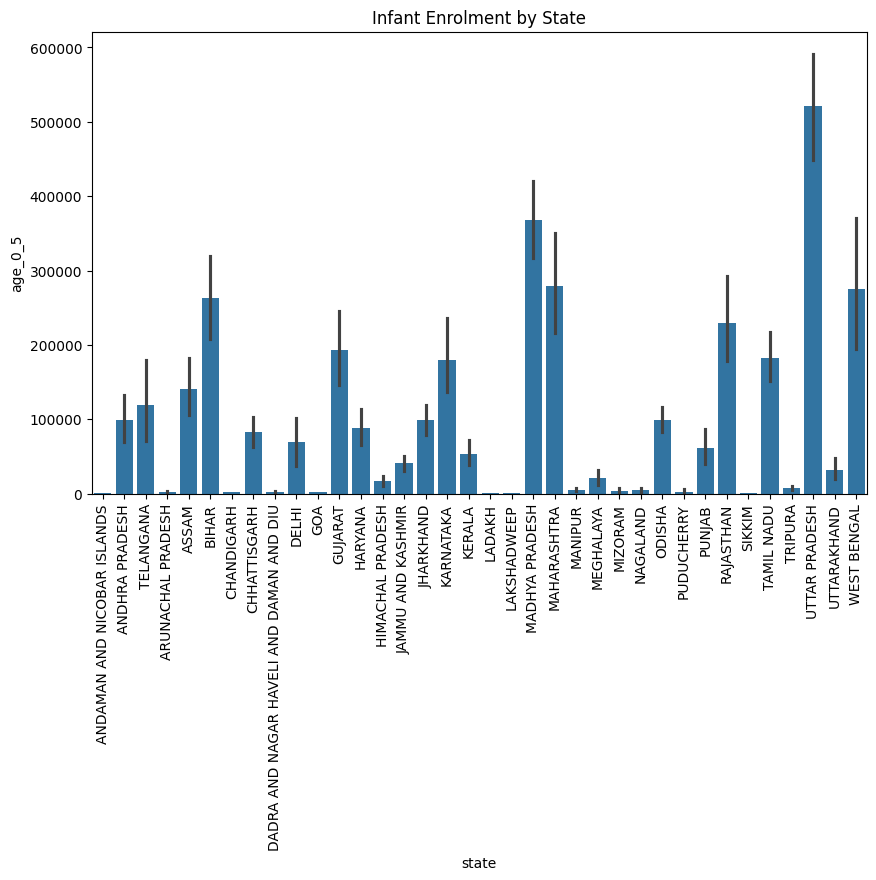

In [8]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(x='state', y='age_0_5', data=enrolment_df, estimator=sum)
plt.title("Infant Enrolment by State")
plt.xticks(rotation=90)
plt.show()

## Infant Aadhaar enrolment density

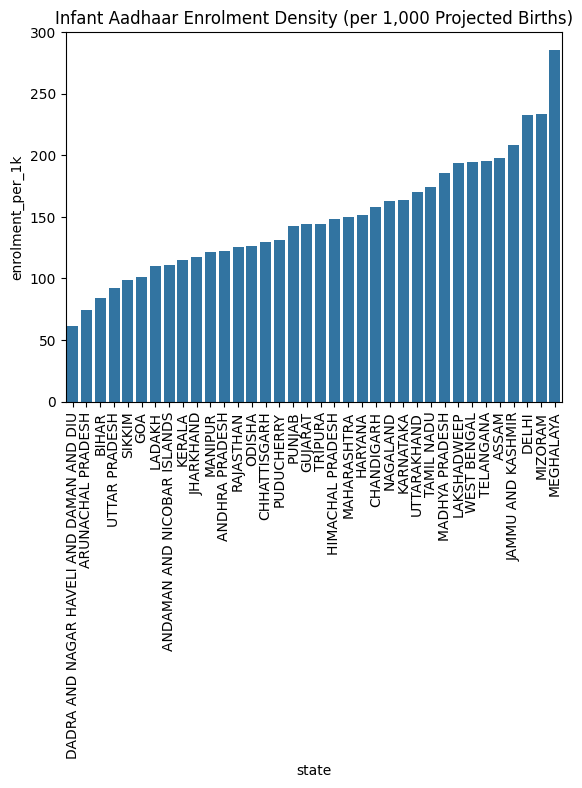

In [9]:
import matplotlib.pyplot as plt

# Assuming birth_projections and enrolment_df are loaded
# Calculate Enrolments per 1,000 infants
norm_df = pd.merge(state_performance, birth_projections, on='state')
norm_df['enrolment_per_1k'] = (norm_df['age_0_5'] / norm_df['estimated number of infants']) * 1000

# Visualize the normalized metric
import seaborn as sns
sns.barplot(x='state', y='enrolment_per_1k', data=norm_df.sort_values('enrolment_per_1k'))
plt.title("Infant Aadhaar Enrolment Density (per 1,000 Projected Births)")
plt.xticks(rotation=90)
plt.show()

- Raw Aadhaar enrolment numbers can be misleading when comparing regions of different population sizes.
- State A appears worse in absolute terms (10,000 missing vs 6,000), but normalization tells a different story.
- After adjusting for projected births, State A has ~90% coverage while State B has only ~40% coverage.
- Thus, normalization (enrolment per 1,000 births) reveals State B as the more critical “identification blindspot” despite smaller raw numbers.

## Top 10 states by enrolment

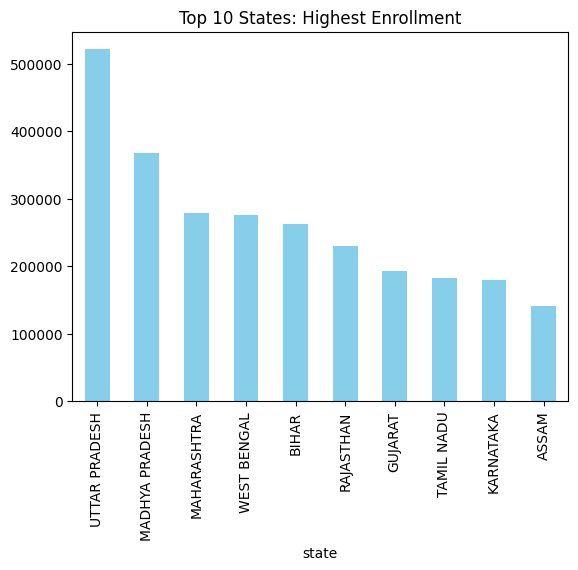

In [10]:
top_10 = enrolment_df.groupby('state')['age_0_5'].sum().nlargest(10)
top_10.plot(kind='bar', color='skyblue', title='Top 10 States: Highest Enrollment')
plt.show()

## Bottom 10 states by enrolment

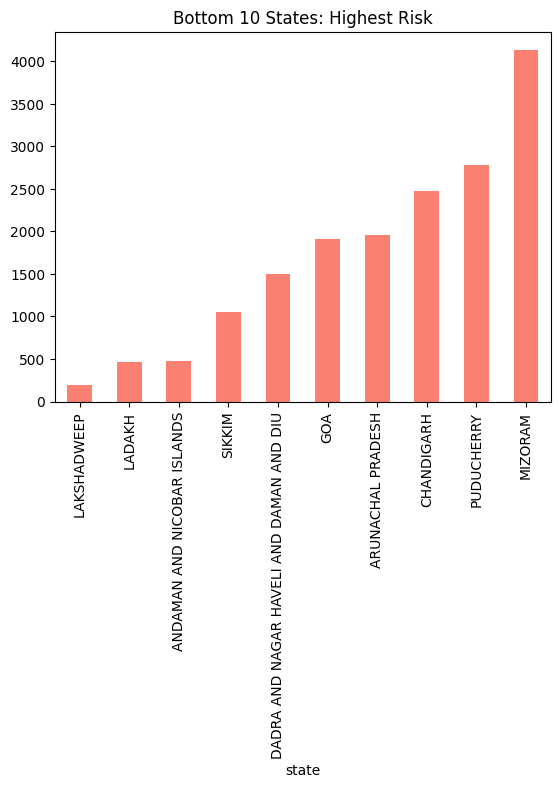

In [11]:
bottom_10 = enrolment_df.groupby('state')['age_0_5'].sum().nsmallest(10)
bottom_10.plot(kind='bar', color='salmon', title='Bottom 10 States: Highest Risk')
plt.show()

# Bivariate Analysis
## % of missing infants

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure birth_projections has 'state' column and uppercase values for merging
# and standardize 's.no.'
if 'state/ut' in birth_projections.columns:
    birth_projections.rename(columns={'state/ut': 'state'}, inplace=True)
if 's.no.' in birth_projections.columns:
    birth_projections.rename(columns={'s.no.': 's_no'}, inplace=True)

# Ensure state column values are uppercase for consistency with other dataframes
birth_projections['state'] = birth_projections['state'].str.upper()

# 1. Data Aggregation & Merging
state_gap = enrolment_df.groupby('state')['age_0_5'].sum().reset_index()
shadow_pop = pd.merge(state_gap, birth_projections, on='state')

# 2. Advanced Metrics Calculation
# Gap = (Projected Births - Actual Aadhaar Enrolments)
shadow_pop['unreached_infants'] = shadow_pop['estimated number of infants'] - shadow_pop['age_0_5']
shadow_pop['unreached_pct'] = (shadow_pop['unreached_infants'] / shadow_pop['estimated number of infants']) * 100

# Sort by severity for the plot
shadow_pop = shadow_pop.sort_values(by='unreached_pct', ascending=False).head(15)

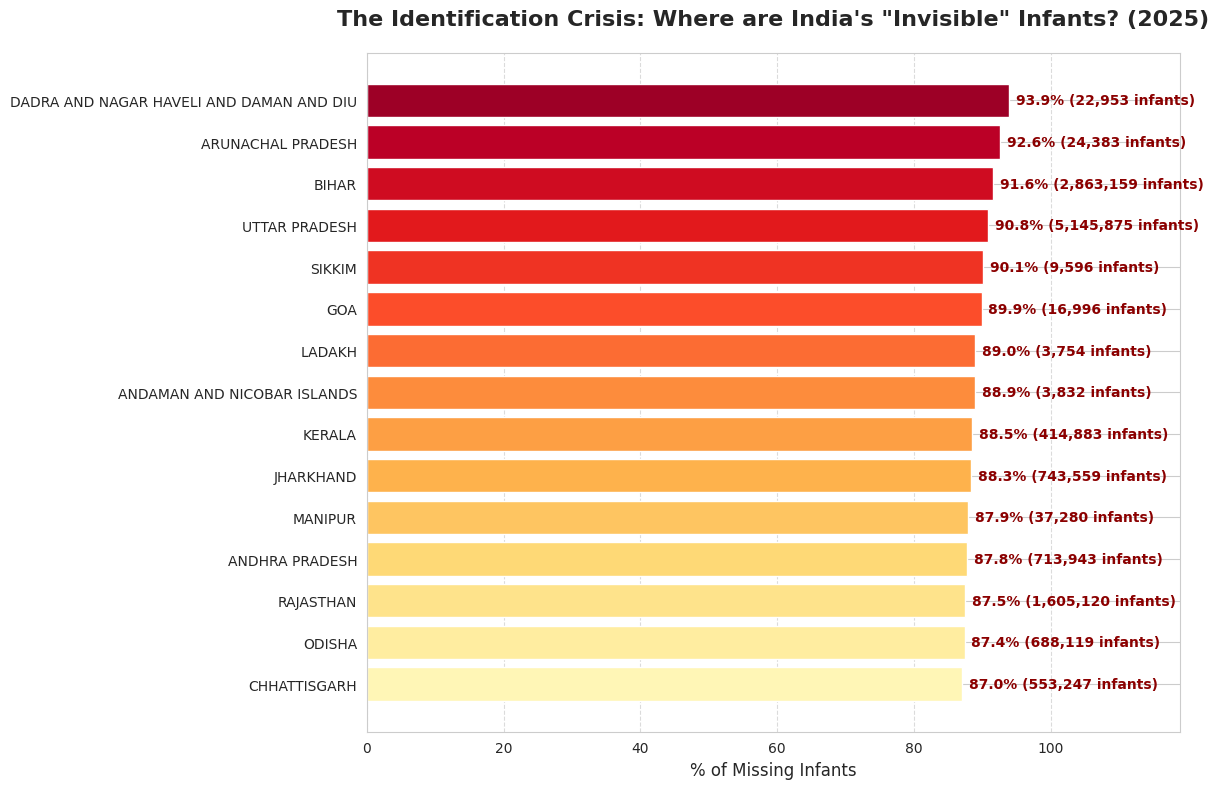

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Sort by the Identification Gap (%) for maximum impact
# We show the top 15 states where the system is most "broken"
plot_data = shadow_pop.sort_values('unreached_pct', ascending=True).tail(15)

# 2. Set the style
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# 3. Create a Horizontal Bar Chart
# Use a color gradient from orange to deep red to signal "Urgency"
colors = sns.color_palette("YlOrRd", n_colors=len(plot_data))
bars = plt.barh(plot_data['state'], plot_data['unreached_pct'], color=colors)

# 4. Add "Data Callouts" (The Impact)
# We put the actual count of missing infants next to each bar
for i, bar in enumerate(bars):
    width = bar.get_width()
    count = f"{plot_data.iloc[i]['unreached_infants']:,.0f} infants"
    plt.text(width + 1, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}% ({count})',
             va='center', fontsize=10, fontweight='bold', color='darkred')

# 5. Final Polish
plt.title('The Identification Crisis: Where are India\'s "Invisible" Infants? (2025)',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('% of Missing Infants', fontsize=12)
plt.xlim(0, max(plot_data['unreached_pct']) + 25) # Add space for labels
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save for your presentation
plt.savefig('impactful_shadow_population.png')
plt.show()

This chart isn't just showing numbers; it's showing the % of children we cannot see, helping us decide where our mobile vaccination vans are needed most

## Biometric updates vs. initial enrolment

/tmp/ipython-input-456074191.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='state', y='maintenance_ratio', data=bio_comparison, palette='RdYlGn')


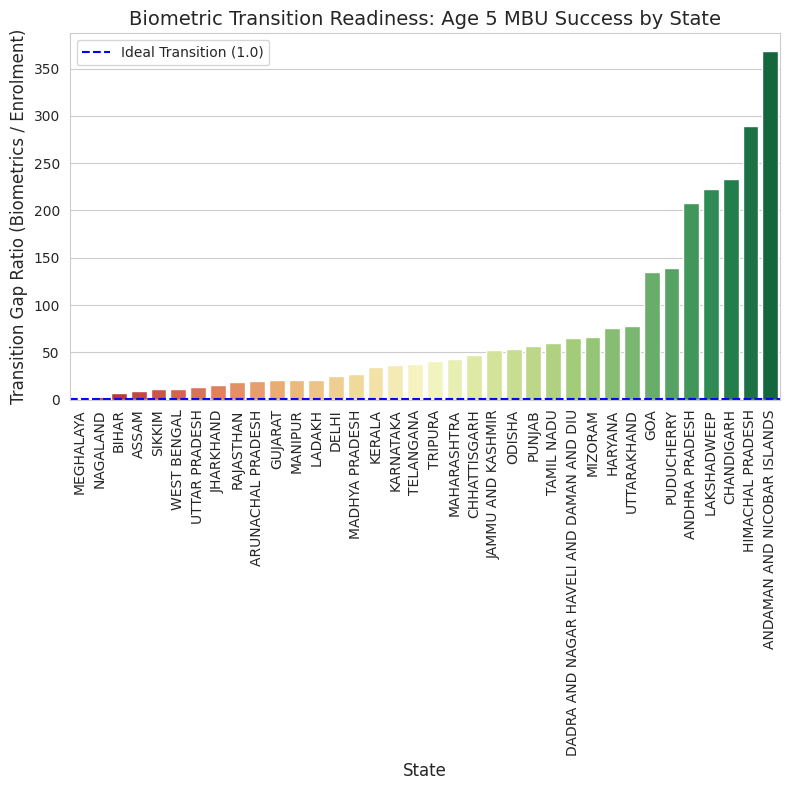

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
state_enrol = enrolment_df.groupby('state')['age_5_17'].sum().reset_index()
state_bio = biometric_df.groupby('state')['bio_age_5_17'].sum().reset_index()

comparison_5_17 = pd.merge(state_enrol, state_bio, on='state')
comparison_5_17['maintenance_ratio'] = comparison_5_17['bio_age_5_17'] / comparison_5_17['age_5_17']
# 1. Sort the data for a clearer visualization
bio_comparison = comparison_5_17.sort_values(by='maintenance_ratio')

# 2. Create the plot
plt.figure(figsize=(8, 8))
sns.barplot(x='state', y='maintenance_ratio', data=bio_comparison, palette='RdYlGn')

# 3. Add a reference line at 1.0 (The ideal scenario where everyone updates)
plt.axhline(1.0, color='blue', linestyle='--', label='Ideal Transition (1.0)')

# 4. Add labels and title
plt.title('Biometric Transition Readiness: Age 5 MBU Success by State', fontsize=14)
plt.ylabel('Transition Gap Ratio (Biometrics / Enrolment)', fontsize=12)
plt.xlabel('State', fontsize=12)
plt.xticks(rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

States with bars significantly shorter than the blue dashed line (Ratio < 1.0) are regions where children are "falling out" of the system.

## Comparing two age groups across states

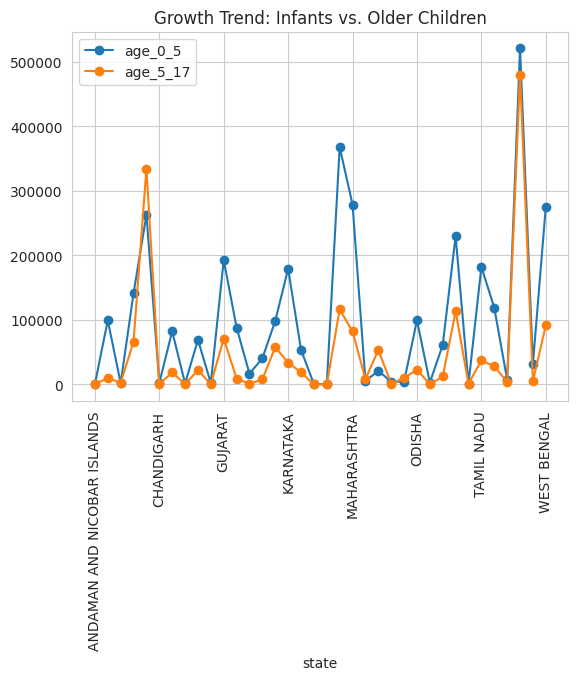

In [15]:
enrol_trends = enrolment_df.groupby('state')[['age_0_5', 'age_5_17']].sum()
enrol_trends.plot(kind='line', marker='o', title='Growth Trend: Infants vs. Older Children')
plt.xticks(rotation=90)
plt.show()

## District level enrolment comparison

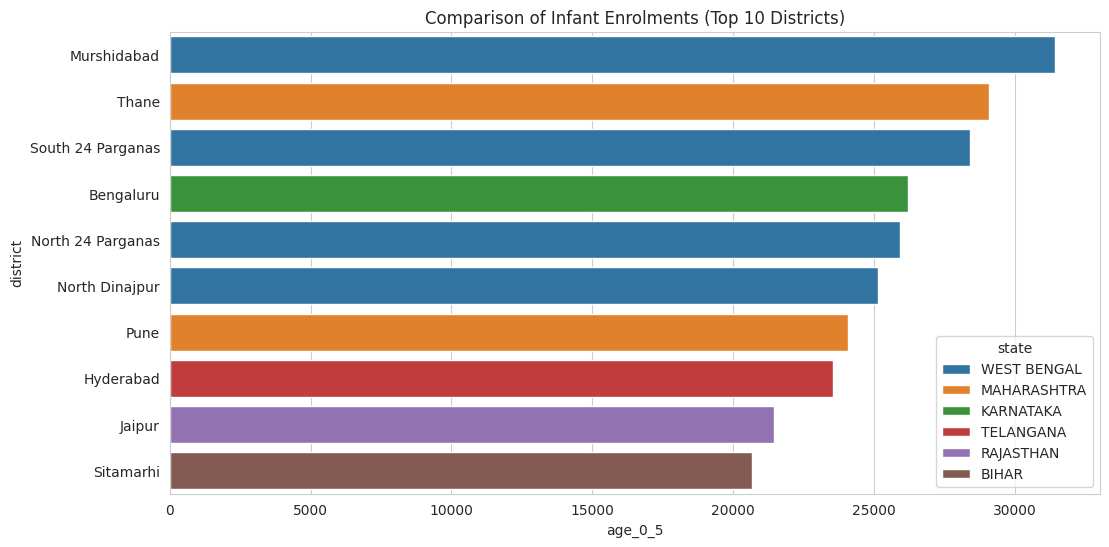

In [16]:
# Aggregate by District and State
district_comparison = enrolment_df.groupby(['state', 'district'])['age_0_5'].sum().reset_index()

# Sort to find Top 10 High-Growth vs. Low-Growth Districts
top_districts = district_comparison.sort_values(by='age_0_5', ascending=False).head(10)

# Visualization: District Comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=top_districts, x='age_0_5', y='district', hue='state')
plt.title("Comparison of Infant Enrolments (Top 10 Districts)")
plt.show()

# Trivariate Analysis
## Enrollment vs. Biometric Transition Analysis



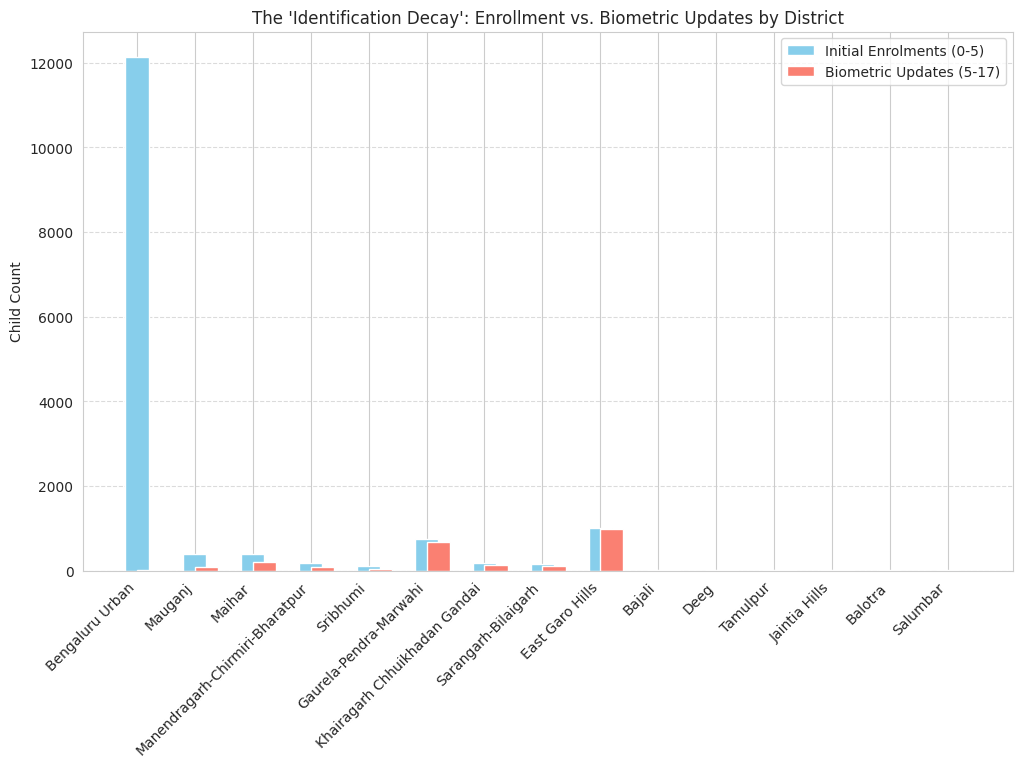

Top 5 Districts with the Highest Lifecycle Gap:
              state                         district  unregistered_gap
298       KARNATAKA                  Bengaluru Urban             12103
371  MADHYA PRADESH                          Mauganj               296
368  MADHYA PRADESH                           Maihar               182
150    CHHATTISGARH  Manendragarh-Chirmiri-Bharatpur                98
85            ASSAM                         Sribhumi                73


In [17]:
# Aggregate counts by State/District
# We focus on the 0-5 and 5-17 brackets to see the lifecycle transition
enrol_agg = enrolment_df.groupby(['state', 'district'])['age_0_5'].sum().reset_index()
bio_agg = biometric_df.groupby(['state', 'district'])['bio_age_5_17'].sum().reset_index()

# 3. Merge and Calculate the "Unregistered/Dropout" Gap
comparison_df = pd.merge(enrol_agg, bio_agg, on=['state', 'district'], how='inner')

# Unregistered Gap = Potential population that didn't complete the transition
comparison_df['unregistered_gap'] = comparison_df['age_0_5'] - comparison_df['bio_age_5_17']
# Normalize as a Ratio (Readiness Score)
comparison_df['readiness_ratio'] = comparison_df['bio_age_5_17'] / comparison_df['age_0_5']

# 4. Sorting for the Top 15 "High-Neglect" Districts
top_gap_districts = comparison_df.sort_values(by='unregistered_gap', ascending=False).head(15)

# 5. Plotting the Comparison
plt.figure(figsize=(12, 7))
x = range(len(top_gap_districts))

plt.bar(x, top_gap_districts['age_0_5'], width=0.4, label='Initial Enrolments (0-5)', align='center', color='skyblue')
plt.bar(x, top_gap_districts['bio_age_5_17'], width=0.4, label='Biometric Updates (5-17)', align='edge', color='salmon')

plt.xticks(x, top_gap_districts['district'], rotation=45, ha='right')
plt.ylabel("Child Count")
plt.title("The 'Identification Decay': Enrollment vs. Biometric Updates by District")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Output the Hit List for the PDF
print("Top 5 Districts with the Highest Lifecycle Gap:")
print(top_gap_districts[['state', 'district', 'unregistered_gap']].head(5))

A child who doesn't come back for their Aadhaar update at age 5 is almost certainly the same child who is missing their booster vaccinations. This chart tells the government exactly where to send mobile vans to 're-capture' these children before they become completely invisible to the health and education systems.

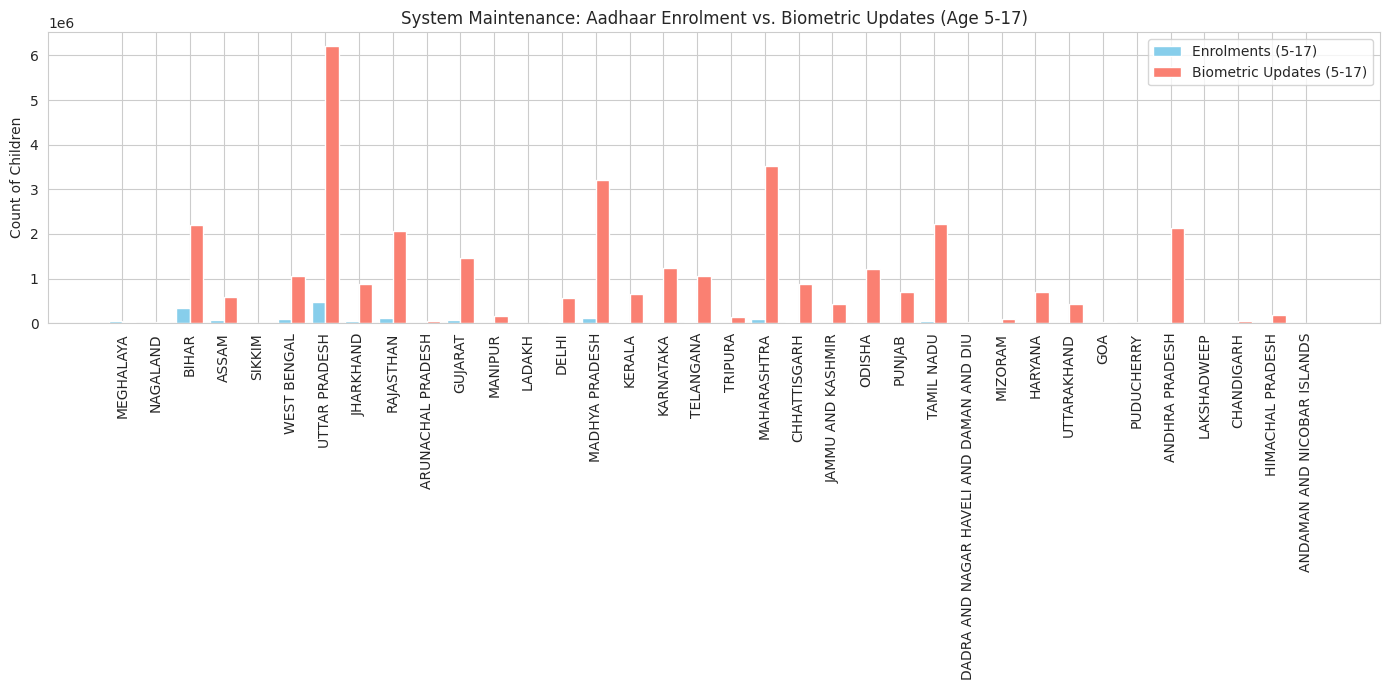

Top 5 States with the lowest Maintenance Readiness (Age 5-17):
        state  maintenance_ratio
22  MEGHALAYA           0.685320
24   NAGALAND           3.271476
4       BIHAR           6.595482
3       ASSAM           9.028130
29     SIKKIM          11.396371


In [18]:
# 1. Aggregate Enrollment and Biometric data for the 5-17 age group
# 'age_5_17' represents new enrollments, 'bio_age_5_17' represents mandatory updates
state_enrol = enrolment_df.groupby('state')['age_5_17'].sum().reset_index()
state_bio = biometric_df.groupby('state')['bio_age_5_17'].sum().reset_index()

# 2. Merge and Calculate the Maintenance Ratio
# A ratio < 1.0 indicates a "Maintenance Gap" where children are not updating records
comparison_5_17 = pd.merge(state_enrol, state_bio, on='state')
comparison_5_17['maintenance_ratio'] = comparison_5_17['bio_age_5_17'] / comparison_5_17['age_5_17']

# 3. Sort for better visualization
comparison_5_17 = comparison_5_17.sort_values(by='maintenance_ratio')

# 4. Visualization: Side-by-Side Comparison
plt.figure(figsize=(14, 7))
x = range(len(comparison_5_17))
width = 0.4

plt.bar(x, comparison_5_17['age_5_17'], width=width, label='Enrolments (5-17)', color='skyblue')
plt.bar([p + width for p in x], comparison_5_17['bio_age_5_17'], width=width, label='Biometric Updates (5-17)', color='salmon')

plt.xticks([p + width/2 for p in x], comparison_5_17['state'], rotation=90)
plt.ylabel("Count of Children")
plt.title("System Maintenance: Aadhaar Enrolment vs. Biometric Updates (Age 5-17)")
plt.legend()
plt.tight_layout()
plt.savefig('maintenance_readiness_5_17.png')
plt.show()

# Output the findings
print("Top 5 States with the lowest Maintenance Readiness (Age 5-17):")
print(comparison_5_17[['state', 'maintenance_ratio']].head(5))

This analysis compares new enrolments against mandatory biometric updates for the 5–17 age group to measure "System Maintenance Readiness." A low ratio identifies "Maintenance Gaps" where children lack updated biometrics, signaling potential bottlenecks for school-age benefits and administrative follow-ups.

## Biometric Quality as a Proxy for "Systemic Neglect"

Objective: Analyze Mandatory Biometric Update (MBU) success at age 5. Districts with low update ratios suggest that parents have "dropped out" of the system, which correlates with missing final booster doses of vaccines

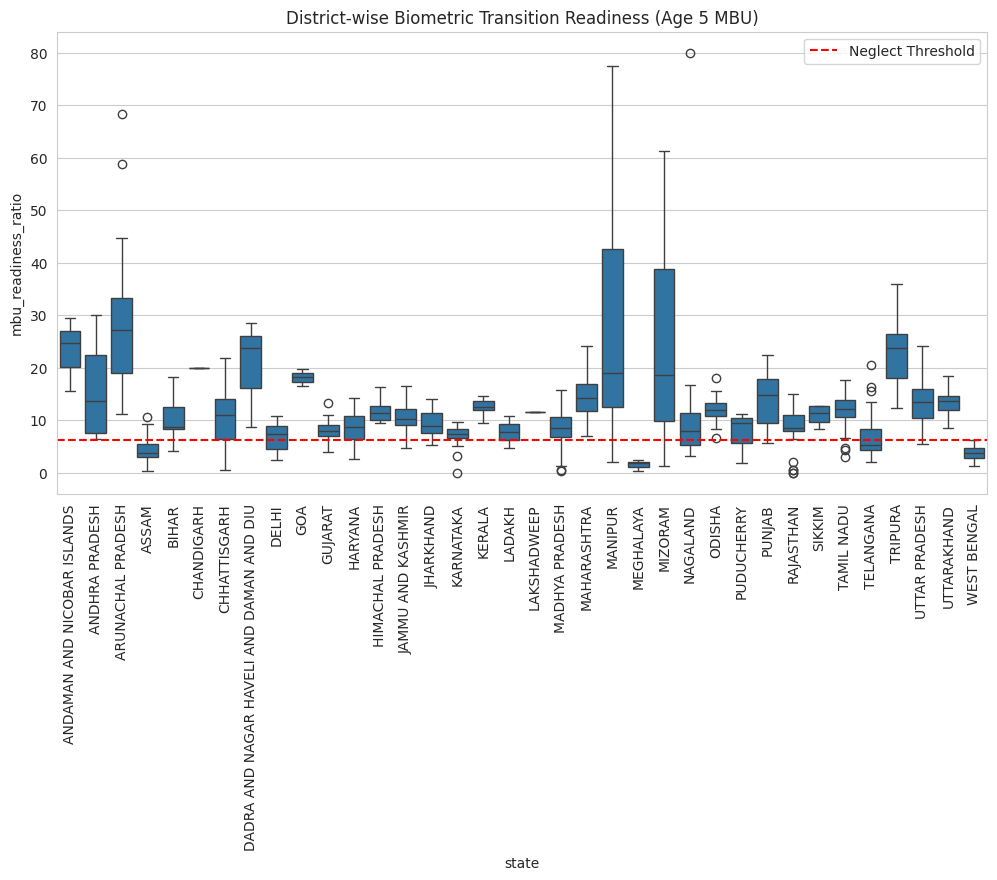

In [19]:
# 1. Calculate the 'Transition Gap' at District Level
# We compare infants (age 0-5) to those returning for MBU (age 5-17)
district_enrol = enrolment_df.groupby(['state', 'district'])['age_0_5'].sum().reset_index()
district_bio = biometric_df.groupby(['state', 'district'])['bio_age_5_17'].sum().reset_index()

# 2. Merge to find the Dropout Rate
transition_analysis = pd.merge(district_enrol, district_bio, on=['state', 'district'])
transition_analysis['mbu_readiness_ratio'] = (transition_analysis['bio_age_5_17'] /
                                               transition_analysis['age_0_5'])

# 3. Label 'Systemic Neglect' Areas
# A ratio < 0.2 indicates that for every 5 infants enrolled, only 1 is returning for MBU
neglect_threshold = transition_analysis['mbu_readiness_ratio'].quantile(0.2)
transition_analysis['neglect_flag'] = transition_analysis['mbu_readiness_ratio'] < neglect_threshold

# 4. Visualize the 'Neglect' clusters
plt.figure(figsize=(12, 6))
sns.boxplot(data=transition_analysis, x='state', y='mbu_readiness_ratio')
plt.xticks(rotation=90)
plt.axhline(neglect_threshold, ls='--', color='red', label='Neglect Threshold')
plt.title("District-wise Biometric Transition Readiness (Age 5 MBU)")
plt.legend()
plt.show()

Y axis - shows the percentage of children who successfully completed their Mandatory Biometric Update (MBU) at age 5 compared to those who initially enrolled as infants.

X axis - states

Red Dashed Line - Any district or state falling below this line is considered at risk for systemic neglect, meaning children in these areas are "falling out" of the digital system and likely missing health services.

# Insights & Action Plan
## State action plan: extra effort needed to reach every child
(The final "Push Index" for the government)

/tmp/ipython-input-2401000303.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='extra_effort', y='state', data=state_push, palette='Reds_r')


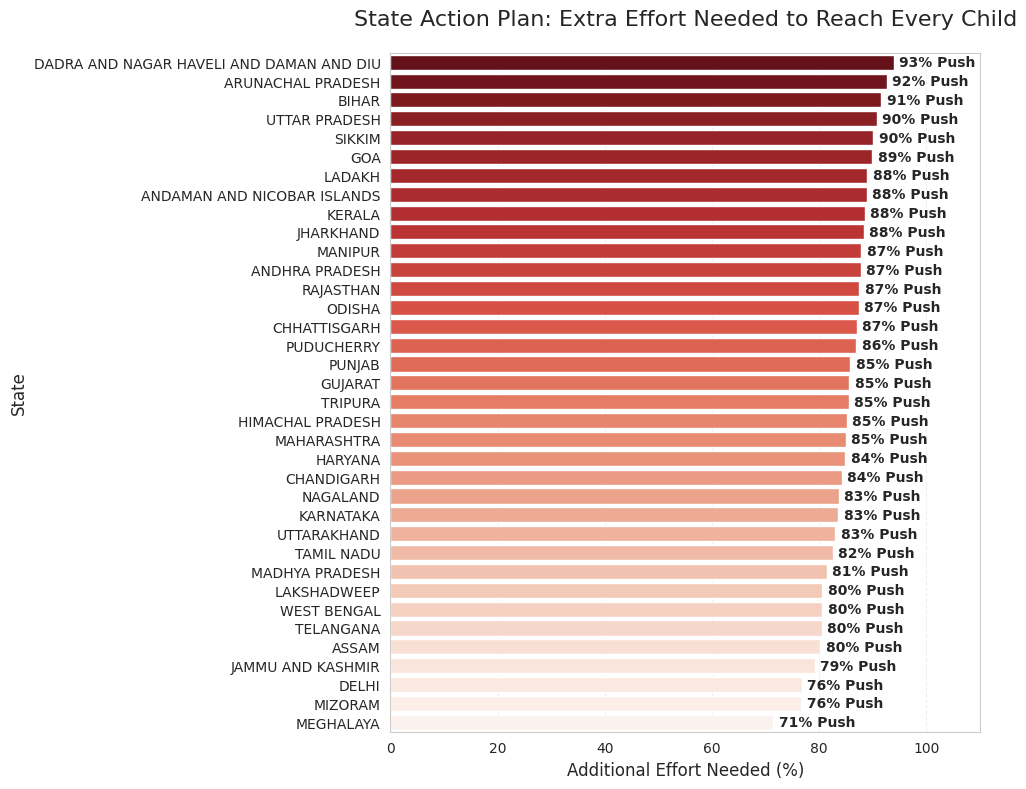

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate the 'Extra Effort' needed for each state
state_enrol = enrolment_df.groupby('state')['age_0_5'].sum().reset_index()
state_push = pd.merge(state_enrol, birth_projections, on='state')

# Extra Effort = 100% minus current coverage
state_push['coverage'] = (state_push['age_0_5'] / state_push['estimated number of infants']) * 100
state_push['extra_effort'] = 100 - state_push['coverage']

# Sort states by urgency (highest push needed at the top)
state_push = state_push.sort_values('extra_effort', ascending=False)

# 2. Simple Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x='extra_effort', y='state', data=state_push, palette='Reds_r')

# Add percentage labels directly on the bars for clarity
for i, val in enumerate(state_push['extra_effort']):
    plt.text(val + 1, i, f'{int(val)}% Push', va='center', fontweight='bold')

# Simplified Titles for the Jury
plt.title('State Action Plan: Extra Effort Needed to Reach Every Child', fontsize=16, pad=20)
plt.xlabel('Additional Effort Needed (%)', fontsize=12)
plt.ylabel('State', fontsize=12)
plt.xlim(0, 110)
plt.grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

Ministry of Health: 'Don't treat every state the same.' The states at the top of this list need Priority Resource Allocation—more mobile vans, more workers, and more funding—because they have the largest 'Push' remaining to ensure no child is left zero-dose.

# Final policy recommendations into actionable steps for the government:

- Prioritise vaccination resources using the State Push Index, focusing on high-risk states with the largest infant identification gaps.

- Deploy integrated mobile units that combine Aadhaar enrolment and on-site vaccination in high-risk districts.

- Address enrolment dropouts through school health camps that link mandatory Aadhaar updates with booster vaccinations.

- Concentrate resources on high-impact districts identified as major enrolment blindspots to achieve faster coverage gains.

- Enable pincode-level targeting for frontline health workers to support precise and effective outreach.